# 预估比例

这章主要讲如何选择 prior distributions。

In [1]:
import numpy as np 
from empiricaldist import Pmf 
import matplotlib.pyplot as plt 
import pandas as pd
from scipy.stats import binom 

一枚硬币，随机抛掷 250 次，观测的结果是 140 次正面朝上，110 次背面朝上。将这枚硬币随机抛掷一次，是正面朝上的概率最有可能是多少？

![](media/coins.jpeg)

**上图来自[搜狐](https://www.sohu.com/a/225881799_100071627)**

我们可以用「分布」那部分的例子来思考。我们可以把这个问题转化为：

我们目前有 $n$ 枚硬币，其各有如下特征：

- 随机抛硬币 0，正面朝上的概率是 0/n
- 随机抛硬币 1，正面朝上的概率是 1/n
- 随机抛硬币 2，正面朝上的概率是 2/n\
...
- 随机抛硬币 n，正面朝上的概率是 n/n

我们从这些硬币中随机挑了一枚，随机抛掷 250 次，观测的结果是 140 次正面朝上，110 次背面朝上。这枚硬币最有可能是哪枚硬币？

我们先用 uniform prior，也就是说，每一枚硬币是该硬币的概率相同。

In [2]:
# 稍微修改一下之前的 update_bowls_pmf
def update_coins_pmf(n, h, t):
    """
    n: 总共几枚硬币
    h: 正面朝上
    t: 背面朝上
    """
    hypos = np.linspace(0, 1, n+1)
    prior = Pmf(1, hypos)
    likelihood_head = [i/(n-1) for i in range(n+1)]
    likelihood_tail = [1- i for i in likelihood_head]
    likelihood = {
        "head": likelihood_head,
        "tail": likelihood_tail
    }
    dataset = ["head"]*h + ["tail"]*t
    posterior = prior.copy()
    for data in dataset:
        posterior *= likelihood[data]
    posterior.normalize()
    return posterior

In [3]:
hypos = np.linspace(0, 1, 10)
hypos

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [4]:
prior = Pmf(1, hypos)
prior

,probs
0.000000,1
0.111111,1
0.222222,1
0.333333,1
0.444444,1
0.555556,1
0.666667,1
0.777778,1
0.888889,1
1.000000,1


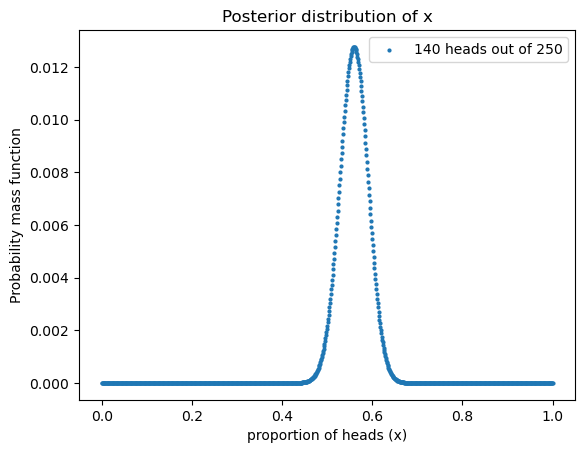

In [5]:
posterior = update_coins_pmf(1000, 140, 110)
df = pd.DataFrame(posterior, columns=['probs'])
df = df.reset_index(names = "proportion of heads (x)")
df.plot.scatter(x = "proportion of heads (x)", y="probs", 
                s = 4,
                label = "140 heads out of 250")
# posterior.plot(label="posterior", color="steelblue")
# plt.xlabel("Proportion of heads (x)")
plt.ylabel("Probability mass function")
plt.legend()
plt.title("Posterior distribution of x")
plt.show()

上面我们用到的是 uniform prior：

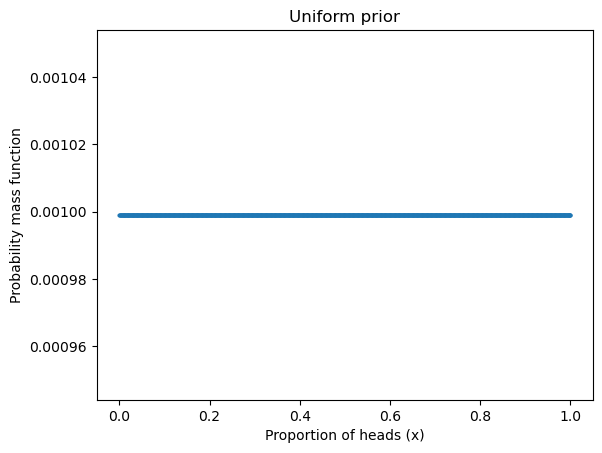

In [6]:
hypos = np.linspace(0, 1, 1001)
uniform = Pmf(1, hypos, name = "uniform")
uniform.normalize()
df = pd.DataFrame(uniform)
df = df.reset_index(names = "proportion of heads (x)")
df.plot.scatter(x = "proportion of heads (x)", y="uniform", s= 4)
# uniform.plot(label="proportion of heads (x)", color="steelblue")
plt.xlabel("Proportion of heads (x)")
plt.ylabel("Probability mass function")
plt.title("Uniform prior")
plt.show()

但是该 prior 并不一定是 uniform 的，也可能是这样子：

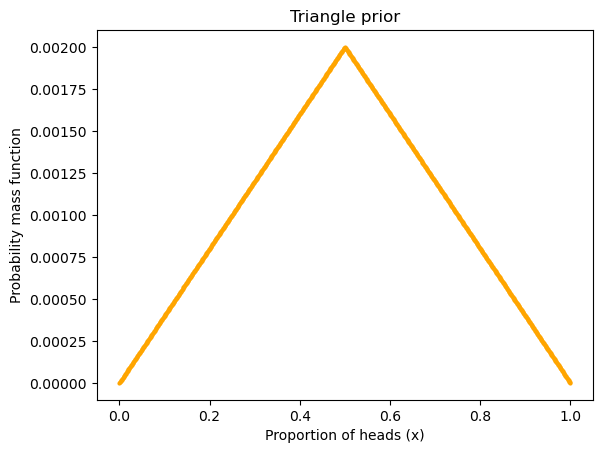

In [7]:
hypos = np.linspace(0, 1, 1001)
ramp_up = np.arange(500)
ramp_down = np.arange(500, -1, -1)
a = np.append(ramp_up, ramp_down)
triangle = Pmf(a, hypos, name = "triangle")
triangle.normalize()
df = pd.DataFrame(triangle)
df = df.reset_index(names = "proportion of heads (x)")
df.plot.scatter(
    x = "proportion of heads (x)", 
    y="triangle", 
    color = "orange",
    s = 4
    )
# triangle.plot(label="proportion of heads (x)", color="steelblue")
plt.xlabel("Proportion of heads (x)")
plt.ylabel("Probability mass function")
plt.title("Triangle prior")
plt.show()

如果我们用如此的 prior，结果是什么呢：

In [8]:
# 稍微修改一下之前的 update_coins_pmf 以便可以修改 prior 
def update_coins_pmf(n, h, t):
    """
    n: 总共几枚硬币
    h: 正面朝上
    t: 背面朝上
    """
    hypos = np.linspace(0, 1, n+1)
    ramp_up = np.arange(n/2)
    ramp_down = np.arange(n/2, -1, -1)
    a = np.append(ramp_up, ramp_down)
    prior = Pmf(a, hypos, name = "triangle")
    likelihood_head = [i/(n-1) for i in range(n+1)]
    likelihood_tail = [1- i for i in likelihood_head]
    likelihood = {
        "head": likelihood_head,
        "tail": likelihood_tail
    }
    dataset = ["head"]*h + ["tail"]*t
    posterior = prior.copy()
    for data in dataset:
        posterior *= likelihood[data]
    posterior.normalize()
    return posterior

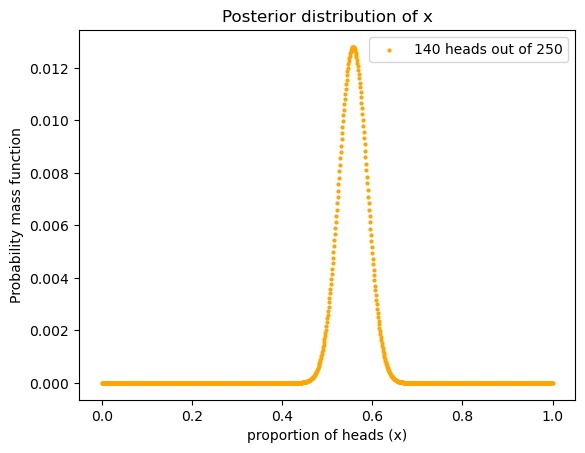

In [9]:
posterior = update_coins_pmf(n = 1000, h = 140, t = 110)
df = pd.DataFrame(posterior)
df = df.reset_index(names = "proportion of heads (x)")
df.plot.scatter(
    x = "proportion of heads (x)", 
    y="triangle", 
    label = "140 heads out of 250",
    color = "orange",
    s= 4
    )
# posterior.plot(label="posterior", color="steelblue")
# plt.xlabel("Proportion of heads (x)")
plt.ylabel("Probability mass function")
plt.legend()
plt.title("Posterior distribution of x")
plt.show()

我们看到和用 uniform prior 结果差不多。这说明什么？这说明数据够多的话，prior 对 posterior 的影响没那么大。

## Batch updating

上面我们是一个数据点一个数据点地在更新 posterior：

```py
for data in dataset:
    posterior *= likelihood[data]
```

我们能不能直接得到一串的 likelihood，这样两个向量逐元素想乘以 (element-wise multiplication) 就可以了？我们需要用到 binomial distribution 公式：

$$P(X = k) = \binom{n}{k} p^k (1-p)^{n-k}$$

我们用 [`scipy.stats.binom`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html)。

```
scipy.stats.binom.pmf(k, n, p)
```

其中 k 是正面朝上的次数，n 是总攻抛掷的次数， p 是正面朝上的概率。需要注意的是，p 可以是一个数，也可以是一组数。当 p 是一个数时，其结果是一个数。当 p 是一组数时，结果是一组数。

In [10]:
def update_binom(heads, tosses, prior):
    """
    heads: number of heads 
    tosses: total tosses 
    prior: prior distribution; should be a empiricaldist.pmf object (a Series)
    """
    # 0/n, 1/n, 2/n ...
    coin_head_probabilities = prior.qs
    likelihood = binom.pmf(k = heads, n = tosses, p = coin_head_probabilities)
    posterior = prior.copy()
    posterior *= likelihood 
    posterior.normalize()
    return posterior

Text(0.5, 1.0, 'Posterior distribution of x')

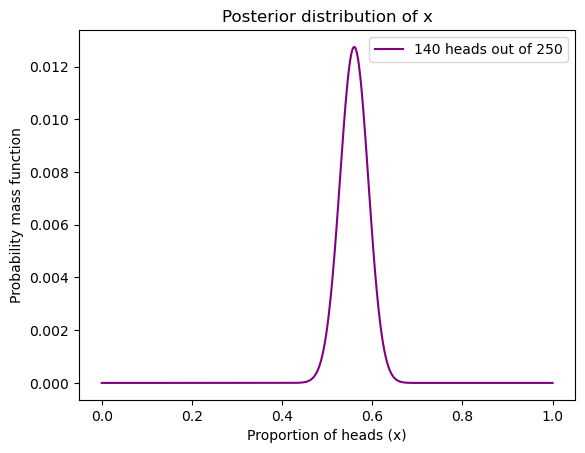

In [11]:
# n: number of coins
n = 1001
tosses = 250
# number of heads out of 250 tosses
heads = 140
hypos = np.linspace(0, 1, n)
uniform2 = Pmf(1, hypos, name = "uniform2")
posterior = update_binom(heads, tosses, uniform2)
posterior.plot(label = "140 heads out of 250", color="purple")
plt.legend()
plt.xlabel("Proportion of heads (x)")
plt.ylabel("Probability mass function")
plt.title("Posterior distribution of x")
# 这里为了简单，我把 discrete distribution 画成了 continuous 的，希望不会造成读者误解。
# 其实，当 n 无限大时，最终的结果就是下面这样